**In this section I test the performance of a model that only considers one area at a time. For each area the model uses the following feautures:**  

*   all of the rain gauge measurements
*   the distance of every rain gauge to the center of the catchment 
*   aggregated statistics regarding the catchment the model is predicting on

**The image below represents the radar (color of the catchment) and the rain gauge measuements (color of the points). The scala is also represented below and goes from violet (no precipitation) to yellow (heavy rain).**

**It is possible to notice that sometimes the two measurements are not correlated. As shown in the image below, radar data measured heavy precipitations for that particular day in the central catchment (inside the red circle), in fact its color is green/yellow. However, the rain gauges that are within the catchment didn't measure any precipitation (violet color).**

**By using the rain gauges of the entire area  and the distance of the rain gauges to the catchment I am trying to predict, I hope to better predict the radar data. Aggregated statistics for each catchments should give additional information for the catchment the model is predicting on.
As aggregated statistics I used:**
*   Minimum
*   Maximum
* Mean
* Median
* Quantiles (every 10%)

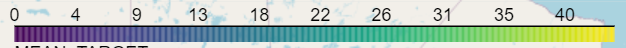

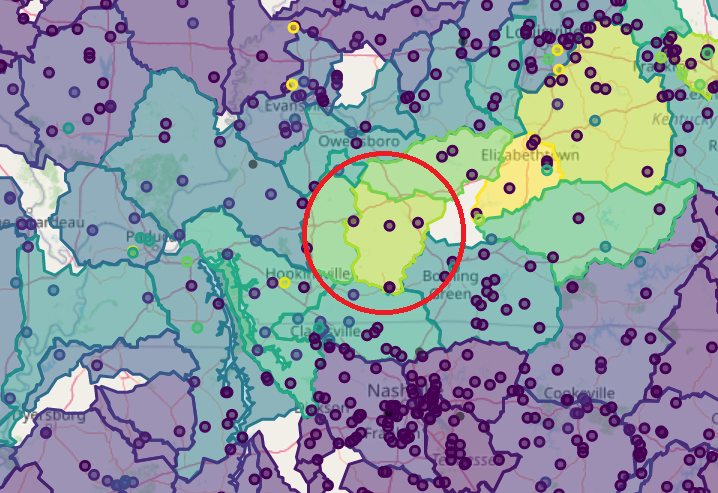

In [3]:
!pip install snowflake-connector-python
!pip install pyarrow==8.0.0
!pip install tensorflow-addons
%pip install geopandas
%pip install Fiona
%pip install folium matplotlib mapclassify
!pip install snowflake-connector-python
!pip install tpot
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 KB 7.7 MB/s eta 0:00:00
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.0.1
    Uninstalling charset-normalizer-3.0.1:
      Successfully uninstalled charset-normalizer-3.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Fo

We uploaded the tables on snowflake. The following cells are only needed for setting up the connection with snowflake.

In [4]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import folium
import snowflake.connector
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import snowflake.connector
from sklearn.model_selection import cross_val_score
from math import sqrt


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.legend()
  plt.grid(True)


ctx = snowflake.connector.connect(
                user="...",
                password="...",
                account="rz80876",
                region="eu-central-1",
                warehouse="PUBLIC",
                database="RAIN",
                schema="PUBLIC"
                )

pd.set_option('display.max_columns', None)


DatabaseError: ignored

## Testing on a single area


The area I select is 2x2 units in latitude and longitude and serves as an example, but the same can be applied to any other area, as it will be shown in the next session.


Since the database won't be online after the handover, I saved the dataframe in the file called "all_gauges_from_area.csv". The following cell won't run.

In [ ]:
# sql_query = """SELECT  m.station, m.measurement_date , MONTH(m.measurement_date), m.prcp, t.mean_target, f.HYBAS_ID, c.Area, c.Altitude_Mean, c.Altitude_Max, c.Altitude_Min, c.Num_Gauges, c.Side, c.Coast, c.Lake, c.Slope_Min, c.Slope_Max, c.Slope_Mean
# FROM catchment_features c
# INNER JOIN precipitation_gauge_features f ON f.hybas_id = c.hybas_id
# INNER JOIN precipitation_gauge_measurements m ON m.station = f.station 
# INNER JOIN second_target t ON t.zone = c.hybas_id AND t.date_target = m.measurement_date
# WHERE c.CENTROID_LATITUDE < 37 AND c.CENTROID_LATITUDE > 35 AND c.CENTROID_LONGITUDE  > -82 AND c.CENTROID_LONGITUDE  < -80;"""

# cursor = ctx.cursor()
# cursor.execute(sql_query)
# data = cursor.fetchall()
# num_fields = len(cursor.description)
# columns = [i[0].lower() for i in cursor.description]
# df = pd.DataFrame(data, columns=columns)
# cursor.close()

True

In [5]:
df = pd.read_csv('all_gauges_from_area.csv')

In [6]:
df["measurement_date"] = pd.to_datetime(df["measurement_date"])
df["hybas_id"] = df["hybas_id"].astype(int)
df["prcp"] = df["prcp"].astype(float)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616505 entries, 0 to 616504
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Unnamed: 0                 616505 non-null  int64         
 1   station                    616505 non-null  object        
 2   measurement_date           616505 non-null  datetime64[ns]
 3   month(m.measurement_date)  616505 non-null  int64         
 4   prcp                       605787 non-null  float64       
 5   mean_target                616505 non-null  float64       
 6   hybas_id                   616505 non-null  int64         
 7   area                       616505 non-null  float64       
 8   altitude_mean              616505 non-null  float64       
 9   altitude_max               616505 non-null  float64       
 10  altitude_min               616505 non-null  float64       
 11  num_gauges                 616505 non-null  int64   

In [8]:
df.shape

(616505, 18)

In [9]:
df.station.nunique()

255

In [10]:
df.hybas_id.nunique()

20

In [11]:
df.measurement_date.nunique()

4199

In [12]:
df.hybas_id.unique()

array([7070663220, 7070663440, 7070661200, 7070661260, 7070624010,
       7070656320, 7070614270, 7070614140, 7070610540, 7070620930,
       7070656490, 7070639030, 7070630060, 7070643030, 7070656220,
       7070651020, 7070643040, 7070638920, 7070656440, 7070630010])

The dataframe contains, for each row: 


*   rain gauge measurement (prcp)
*   name of the rain gauge station (station)
*   the date of the measurement (measurement_date)
*   the radar measurement, which is our target variable (mean_target)
*   name of the catchment/watershed (hybas_id)
*   the position in latitude and longitude of the center of the catchment/watershed (centroid_latitude/longitude)
*   other characterists relative to the catchment (altitude_mean, num_gauges etc.)



In [ ]:
df.head()

Unnamed: 0      station measurement_date  month(m.measurement_date)  prcp  \
0           0  US1SCCK0007       2011-11-20                         11   0.0   
1           1  US1SCCK0007       2011-11-21                         11   0.0   
2           2  US1SCCK0007       2011-11-22                         11   8.6   
3           3  US1SCCK0007       2011-11-23                         11   4.8   
4           4  US1SCCK0007       2011-11-24                         11   0.0   

   mean_target    hybas_id          area  altitude_mean  altitude_max  \
0     0.023643  7070663220  4.754251e+09     338.147392        1320.0   
1     9.614969  7070663220  4.754251e+09     338.147392        1320.0   
2     4.290120  7070663220  4.754251e+09     338.147392        1320.0   
3    28.268888  7070663220  4.754251e+09     338.147392        1320.0   
4     0.000000  7070663220  4.754251e+09     338.147392        1320.0   

   altitude_min  num_gauges side  coast  lake  slope_min  slope_max  \
0         117.0          36    M      0     0        0.0  71.042755   
1         117.0          36    M      0     0        0.0  71.042755   
2         117.0          36    M      0     0        0.0  71.042755   
3         117.0          36    M      0     0        0.0  71.042755   
4         117.0          36    M      0     0        0.0  71.042755   

   slope_mean  
0    6.595088  
1    6.595088  
2    6.595088  
3    6.595088  
4    6.595088

### Aggregated statistics computing, for each catchment and date.

The advantage of using aggregated statistic is the fact that can be computed independently of the number of gauges inside the catchment.

In [ ]:
stats = df.groupby(['hybas_id', 'measurement_date'])['prcp'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.10),lambda x: x.quantile(0.20), lambda x: x.quantile(0.30), lambda x: x.quantile(0.40) ,lambda x: x.quantile(0.60), lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), lambda x: x.quantile(0.90)])

stats = stats.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q2', '<lambda_2>': 'q3', '<lambda_3>': 'q4', '<lambda_4>': 'q6', '<lambda_5>': 'q7', '<lambda_6>': 'q8', '<lambda_7>': 'q9'})


In [ ]:
stats

min   max       mean  median    q1     q2  \
hybas_id   measurement_date                                               
7070610540 2015-07-01         5.1   5.1   5.100000     5.1   5.1   5.10   
           2015-07-02         0.5   0.5   0.500000     0.5   0.5   0.50   
           2015-07-03         1.0   1.0   1.000000     1.0   1.0   1.00   
           2015-07-04        28.2  28.2  28.200000    28.2  28.2  28.20   
           2015-07-05         1.8   1.8   1.800000     1.8   1.8   1.80   
...                           ...   ...        ...     ...   ...    ...   
7070663440 2021-06-26         0.0   0.0   0.000000     0.0   0.0   0.00   
           2021-06-27         0.0   0.5   0.125000     0.0   0.0   0.00   
           2021-06-28         0.0   0.0   0.000000     0.0   0.0   0.00   
           2021-06-29         0.8   6.6   2.511111     1.3   0.8   0.92   
           2021-06-30         1.3   4.6   3.042857     3.0   1.9   2.34   

                                q3     q4     q6    q7     q8     q9  
hybas_id   measurement_date                                           
7070610540 2015-07-01         5.10   5.10   5.10   5.1   5.10   5.10  
           2015-07-02         0.50   0.50   0.50   0.5   0.50   0.50  
           2015-07-03         1.00   1.00   1.00   1.0   1.00   1.00  
           2015-07-04        28.20  28.20  28.20  28.2  28.20  28.20  
           2015-07-05         1.80   1.80   1.80   1.8   1.80   1.80  
...                            ...    ...    ...   ...    ...    ...  
7070663440 2021-06-26         0.00   0.00   0.00   0.0   0.00   0.00  
           2021-06-27         0.00   0.00   0.00   0.0   0.30   0.50  
           2021-06-28         0.00   0.00   0.00   0.0   0.00   0.00  
           2021-06-29         1.00   1.06   2.26   2.5   3.94   6.20  
           2021-06-30         2.46   2.70   3.48   3.8   3.80   4.12  

[77856 rows x 12 columns]

### Creation of a df containing all of the rain gauges measurements of the area. I impute missing values.

In [ ]:
dfp = df.pivot(values=["prcp"], index=["measurement_date","hybas_id", "mean_target", "month(m.measurement_date)", "area", "altitude_mean", "altitude_max", "altitude_min", "num_gauges", "coast", "lake", "slope_min", "slope_max", "slope_mean"], columns=["station"])

In [ ]:
dfp.head(5)

prcp  \
station                                                                                                                                                                     US1NCAG0001   
measurement_date hybas_id   mean_target month(m.measurement_date) area         altitude_mean altitude_max altitude_min num_gauges coast lake slope_min slope_max slope_mean               
2010-01-01       7070614140 5.331242    1                         4.737519e+09 881.629906    1720.0       558.0        27         0     0    0.0       53.615608 10.822695          0.5   
                 7070620930 0.535600    1                         6.175200e+08 728.012906    1243.0       526.0        2          0     0    0.0       46.061306 9.200159           NaN   
                 7070624010 0.212692    1                         1.869612e+09 677.798982    1431.0       344.0        3          0     0    0.0       69.711403 13.501952          NaN   
                 7070630010 0.602178    1                         8.244065e+08 424.343037    1066.0       239.0        3          0     0    0.0       48.094204 7.274997           NaN   
                 7070630060 0.435692    1                         3.229629e+09 466.664176    1256.0       240.0        13         0     0    0.0       49.057045 9.827873           NaN   

                                                                                                                                                                                         \
station                                                                                                                                                                     US1NCAG0003   
measurement_date hybas_id   mean_target month(m.measurement_date) area         altitude_mean altitude_max altitude_min num_gauges coast lake slope_min slope_max slope_mean               
2010-01-01       7070614140 5.331242    1                         4.737519e+09 881.629906    1720.0       558.0        27         0     0    0.0       53.615608 10.822695          NaN   
                 7070620930 0.535600    1                         6.175200e+08 728.012906    1243.0       526.0        2          0     0    0.0       46.061306 9.200159           NaN   
                 7070624010 0.212692    1                         1.869612e+09 677.798982    1431.0       344.0        3          0     0    0.0       69.711403 13.501952          NaN   
                 7070630010 0.602178    1                         8.244065e+08 424.343037    1066.0       239.0        3          0     0    0.0       48.094204 7.274997           NaN   
                 7070630060 0.435692    1                         3.229629e+09 466.664176    1256.0       240.0        13         0     0    0.0       49.057045 9.827873           NaN   

                                                                                                                                                                                         \
station                                                                                                                                                                     US1NCAG0004   
measurement_date hybas_id   mean_target month(m.measurement_date) area         altitude_mean altitude_max altitude_min num_gauges coast lake slope_min slope_max slope_mean               
2010-01-01       7070614140 5.331242    1                         4.737519e+09 881.629906    1720.0       558.0        27         0     0    0.0       53.615608 10.822695          NaN   
                 7070620930 0.535600    1                         6.175200e+08 728.012906    1243.0       526.0        2          0     0    0.0       46.061306 9.200159           NaN   
                 7070624010 0.212692    1                         1.869612e+09 677.798982    1431.0       344.0        3          0     0    0.0       69.711403 13.501952          NaN   
                 7070630010 0.602178    1                      

In [ ]:
dfp_prcp = dfp.prcp

In [ ]:
dfp_prcp.head(10)

station                                                                                                                                                                      US1NCAG0001  \
measurement_date hybas_id   mean_target month(m.measurement_date) area         altitude_mean altitude_max altitude_min num_gauges coast lake slope_min slope_max slope_mean                
2010-01-01       7070614140 5.331242    1                         4.737519e+09 881.629906    1720.0       558.0        27         0     0    0.0       53.615608 10.822695           0.5   
                 7070620930 0.535600    1                         6.175200e+08 728.012906    1243.0       526.0        2          0     0    0.0       46.061306 9.200159            NaN   
                 7070624010 0.212692    1                         1.869612e+09 677.798982    1431.0       344.0        3          0     0    0.0       69.711403 13.501952           NaN   
                 7070630010 0.602178    1                         8.244065e+08 424.343037    1066.0       239.0        3          0     0    0.0       48.094204 7.274997            NaN   
                 7070630060 0.435692    1                         3.229629e+09 466.664176    1256.0       240.0        13         0     0    0.0       49.057045 9.827873            NaN   
                 7070638920 0.303049    1                         1.094727e+09 282.007121    720.0        190.0        5          0     0    0.0       41.708599 3.971642            NaN   
                 7070639030 0.129787    1                         6.537400e+08 266.029024    358.0        191.0        10         0     0    0.0       35.043541 2.928922            NaN   
                 7070643030 0.164542    1                         2.343321e+09 292.117195    806.0        176.0        11         0     0    0.0       51.816250 4.423885            NaN   
                 7070643040 0.112334    1                         5.973102e+08 238.679091    331.0        180.0        6          0     0    0.0       23.901857 3.006389            NaN   
                 7070651020 0.039670    1                         2.062726e+09 225.396972    358.0        82.0         9          0     0    0.0       41.596004 3.180186            NaN   

station                                                                                                                                                                      US1NCAG0003  \
measurement_date hybas_id   mean_target month(m.measurement_date) area         altitude_mean altitude_max altitude_min num_gauges coast lake slope_min slope_max slope_mean                
2010-01-01       7070614140 5.331242    1                         4.737519e+09 881.629906    1720.0       558.0        27         0     0    0.0       53.615608 10.822695           NaN   
                 7070620930 0.535600    1                         6.175200e+08 728.012906    1243.0       526.0        2          0     0    0.0       46.061306 9.200159            NaN   
                 7070624010 0.212692    1                         1.869612e+09 677.798982    1431.0       344.0        3          0     0    0.0       69.711403 13.501952           NaN   
                 7070630010 0.602178    1                         8.244065e+08 424.343037    1066.0       239.0        3          0     0    0.0       48.094204 7.274997            NaN   
                 7070630060 0.435692    1                         3.229629e+09 466.664176    1256.0       240.0        13         0     0    0.0       49.057045 9.827873            NaN   
                 7070638920 0.303049    1                         1.094727e+09 282.007121    720.0        190.0        5          0     0    0.0       41.708599 3.971642            NaN   
                 7070639030 0.129787    1                         6.537400e+08 266.029024    358.0        191.0        10         0     0    0.0       35.043541 2.928922            NaN   
                 7070643030 0.164542    1          

The dfp_prcp seems to have many missing values. However it must be considered that each row has a numerical values only for the rain gauge stations that belong to the catchment. By grouping them by date (next cell), it it possible to obtain all of the rain gauge measurements for a certain date.

In [ ]:
grouped = dfp_prcp.groupby(['measurement_date']).max()


In [ ]:
grouped.head(5)

station           US1NCAG0001  US1NCAG0003  US1NCAG0004  US1NCAG0005  \
measurement_date                                                       
2010-01-01                0.5          NaN          NaN          NaN   
2010-01-02                0.0          NaN          NaN          NaN   
2010-01-03                0.0          NaN          NaN          NaN   
2010-01-04                0.0          NaN          NaN          NaN   
2010-01-05                0.0          NaN          NaN          NaN   

station           US1NCAS0001  US1NCAS0002  US1NCAS0010  US1NCAS0012  \
measurement_date                                                       
2010-01-01                NaN          3.8          NaN          NaN   
2010-01-02                NaN          1.3          NaN          NaN   
2010-01-03                NaN          0.3          NaN          NaN   
2010-01-04                NaN          0.5          NaN          NaN   
2010-01-05                NaN          3.3          NaN          NaN   

station           US1NCAS0013  US1NCAS0014  US1NCAS0016  US1NCAS0018  \
measurement_date                                                       
2010-01-01                NaN          NaN          NaN          NaN   
2010-01-02                NaN          NaN          NaN          NaN   
2010-01-03                NaN          NaN          NaN          NaN   
2010-01-04                NaN          NaN          NaN          NaN   
2010-01-05                NaN          NaN          NaN          NaN   

station           US1NCAS0019  US1NCAS0022  US1NCAV0004  US1NCAV0007  \
measurement_date                                                       
2010-01-01                NaN          NaN          NaN          0.0   
2010-01-02                NaN          NaN          NaN          0.3   
2010-01-03                NaN          NaN          NaN          0.0   
2010-01-04                NaN          NaN          0.5          0.0   
2010-01-05                NaN          NaN          NaN          0.3   

station           US1NCAV0009  US1NCAX0005  US1NCAX0006  US1NCAX0007  \
measurement_date                                                       
2010-01-01                NaN          NaN          NaN          NaN   
2010-01-02                NaN          NaN          NaN          NaN   
2010-01-03                NaN          NaN          NaN          NaN   
2010-01-04                NaN          NaN          NaN          NaN   
2010-01-05                NaN          NaN          NaN          NaN   

station           US1NCBC0087  US1NCBC0115  US1NCBK0002  US1NCBK0004  \
measurement_date                                                       
2010-01-01                NaN          NaN          NaN          NaN   
2010-01-02                NaN          NaN          0.0          NaN   
2010-01-03                NaN          NaN          NaN          NaN   
2010-01-04                NaN          NaN          0.0          NaN   
2010-01-05                NaN          NaN          NaN          NaN   

station           US1NCBK0006  US1NCBK0009  US1NCBK0012  US1NCBK0013  \
measurement_date                                                       
2010-01-01                NaN          NaN          NaN          NaN   
2010-01-02                NaN          NaN          NaN          NaN   
2010-01-03                NaN          NaN          NaN          NaN   
2010-01-04                NaN          NaN          NaN          NaN   
2010-01-05                NaN          NaN          NaN          NaN   

station           US1NCCB0008  US1NCCB0010  US1NCCB0015  US1NCCB0020  \
measurement_date                                                       
2010-01-01                1.8          NaN          NaN          NaN   
2010-01-02                0.0          NaN          NaN          NaN   
2010-01-03                0.0          NaN          NaN          NaN   
2010-01-04                0.0          NaN          NaN          NaN   
2010-01-05                0.0    

In [ ]:
grouped.shape

(4199, 255)

The number of nans decreased substantially, however they are still present. So I impute with KNN, which is mostly a solid choice.

In [ ]:
# Set number of neighbors to look for
neighbors = 10

# Initialize KNN regressor
knn_regressor = KNNImputer(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
grouped_imputed = knn_regressor.fit_transform(grouped)

grouped_imputed = pd.DataFrame(grouped_imputed, columns=grouped.columns, index=grouped.index)


In [ ]:
grouped_imputed.head()

station           US1NCAG0001  US1NCAG0003  US1NCAG0004  US1NCAG0005  \
measurement_date                                                       
2010-01-01                0.5     0.251346     0.210234     0.000000   
2010-01-02                0.0     0.000000     0.196219     0.000000   
2010-01-03                0.0     0.000000     0.000000     0.000000   
2010-01-04                0.0     0.000000     0.000000     0.000000   
2010-01-05                0.0     0.000000     0.104276     0.118067   

station           US1NCAS0001  US1NCAS0002  US1NCAS0010  US1NCAS0012  \
measurement_date                                                       
2010-01-01           0.030869          3.8     0.678797     2.115599   
2010-01-02           0.000000          1.3     0.737238     0.816623   
2010-01-03           0.000000          0.3     0.000000     0.000000   
2010-01-04           0.000000          0.5     0.453896     0.352670   
2010-01-05           0.000000          3.3     0.963228     1.654946   

station           US1NCAS0013  US1NCAS0014  US1NCAS0016  US1NCAS0018  \
measurement_date                                                       
2010-01-01           0.183479     0.280560     1.827020     0.882811   
2010-01-02           0.248120     0.243124     0.649900     0.473078   
2010-01-03           0.000000     0.000000     1.951736     0.298154   
2010-01-04           0.000000     0.090170     0.452275     0.506438   
2010-01-05           0.073324     0.435745     0.653260     0.676467   

station           US1NCAS0019  US1NCAS0022  US1NCAV0004  US1NCAV0007  \
measurement_date                                                       
2010-01-01           0.048052     0.779565     1.003572          0.0   
2010-01-02           0.134127     0.639341     0.276723          0.3   
2010-01-03           0.000000     0.000000     0.000000          0.0   
2010-01-04           0.218358     0.130013     0.500000          0.0   
2010-01-05           0.172623     0.451157     1.837528          0.3   

station           US1NCAV0009  US1NCAX0005  US1NCAX0006  US1NCAX0007  \
measurement_date                                                       
2010-01-01           0.621739    11.027281     0.443717     2.168575   
2010-01-02           0.455313    10.621181     0.000000     3.977759   
2010-01-03           0.000000     9.192943     0.000000    21.600000   
2010-01-04           0.136923    10.166030     0.000000     4.177221   
2010-01-05           0.934669     9.753188     0.031186     4.532307   

station           US1NCBC0087  US1NCBC0115  US1NCBK0002  US1NCBK0004  \
measurement_date                                                       
2010-01-01           0.175596     0.748805     0.211298     0.130082   
2010-01-02           0.026386     0.299801     0.000000     0.026850   
2010-01-03           0.000000     0.167780     0.000000     0.000000   
2010-01-04           0.171487     0.651630     0.000000     0.000000   
2010-01-05           0.071883     0.311505     0.041997     0.000000   

station           US1NCBK0006  US1NCBK0009  US1NCBK0012  US1NCBK0013  \
measurement_date                                                       
2010-01-01           2.311059     0.234519     0.031627     0.800699   
2010-01-02           1.207470     0.000000     0.000000     0.205548   
2010-01-03           0.134459     0.000000     0.000000     0.050000   
2010-01-04           0.507637     0.000000     0.273482     0.030543   
2010-01-05           0.137940     0.061650     0.447660     0.796829   

station           US1NCCB0008  US1NCCB0010  US1NCCB0015  US1NCCB0020  \
measurement_date                                                       
2010-01-01                1.8     0.323983     0.527702     0.394928   
2010-01-02                0.0     0.000000     0.000000     0.000000   
2010-01-03                0.0     0.000000     0.000000     0.000000   
2010-01-04                0.0     0.000000     0.000000     0.000000   
2010-01-05                0.0    

By taking the index from the pivoted df (dfp), I can assign the rain gauges measurements I just imputed to each single catchment, by merging. 

In [ ]:
dfp_frame = dfp.index.to_frame().reset_index(drop=True)

In [ ]:
dfp_frame.head()

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-01  7070620930     0.535600                          1   
2       2010-01-01  7070624010     0.212692                          1   
3       2010-01-01  7070630010     0.602178                          1   
4       2010-01-01  7070630060     0.435692                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  6.175200e+08     728.012906        1243.0         526.0           2      0   
2  1.869612e+09     677.798982        1431.0         344.0           3      0   
3  8.244065e+08     424.343037        1066.0         239.0           3      0   
4  3.229629e+09     466.664176        1256.0         240.0          13      0   

   lake  slope_min  slope_max  slope_mean  
0     0        0.0  53.615608   10.822695  
1     0        0.0  46.061306    9.200159  
2     0        0.0  69.711403   13.501952  
3     0        0.0  48.094204    7.274997  
4     0        0.0  49.057045    9.827873

In [ ]:
merged_df = pd.merge(dfp_frame,grouped_imputed, how='left', on='measurement_date')


In [ ]:
merged_df.head()

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-01  7070620930     0.535600                          1   
2       2010-01-01  7070624010     0.212692                          1   
3       2010-01-01  7070630010     0.602178                          1   
4       2010-01-01  7070630060     0.435692                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  6.175200e+08     728.012906        1243.0         526.0           2      0   
2  1.869612e+09     677.798982        1431.0         344.0           3      0   
3  8.244065e+08     424.343037        1066.0         239.0           3      0   
4  3.229629e+09     466.664176        1256.0         240.0          13      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001  US1NCAG0003  \
0     0        0.0  53.615608   10.822695          0.5     0.251346   
1     0        0.0  46.061306    9.200159          0.5     0.251346   
2     0        0.0  69.711403   13.501952          0.5     0.251346   
3     0        0.0  48.094204    7.274997          0.5     0.251346   
4     0        0.0  49.057045    9.827873          0.5     0.251346   

   US1NCAG0004  US1NCAG0005  US1NCAS0001  US1NCAS0002  US1NCAS0010  \
0     0.210234          0.0     0.030869          3.8     0.678797   
1     0.210234          0.0     0.030869          3.8     0.678797   
2     0.210234          0.0     0.030869          3.8     0.678797   
3     0.210234          0.0     0.030869          3.8     0.678797   
4     0.210234          0.0     0.030869          3.8     0.678797   

   US1NCAS0012  US1NCAS0013  US1NCAS0014  US1NCAS0016  US1NCAS0018  \
0     2.115599     0.183479      0.28056      1.82702     0.882811   
1     2.115599     0.183479      0.28056      1.82702     0.882811   
2     2.115599     0.183479      0.28056      1.82702     0.882811   
3     2.115599     0.183479      0.28056      1.82702     0.882811   
4     2.115599     0.183479      0.28056      1.82702     0.882811   

   US1NCAS0019  US1NCAS0022  US1NCAV0004  US1NCAV0007  US1NCAV0009  \
0     0.048052     0.779565     1.003572          0.0     0.621739   
1     0.048052     0.779565     1.003572          0.0     0.621739   
2     0.048052     0.779565     1.003572          0.0     0.621739   
3     0.048052     0.779565     1.003572          0.0     0.621739   
4     0.048052     0.779565     1.003572          0.0     0.621739   

   US1NCAX0005  US1NCAX0006  US1NCAX0007  US1NCBC0087  US1NCBC0115  \
0    11.027281     0.443717     2.168575     0.175596     0.748805   
1    11.027281     0.443717     2.168575     0.175596     0.748805   
2    11.027281     0.443717     2.168575     0.175596     0.748805   
3    11.027281     0.443717     2.168575     0.175596     0.748805   
4    11.027281     0.443717     2.168575     0.175596     0.748805   

   US1NCBK0002  US1NCBK0004  US1NCBK0006  US1NCBK0009  US1NCBK0012  \
0     0.211298     0.130082     2.311059     0.234519     0.031627   
1     0.211298     0.130082     2.311059     0.234519     0.031627   
2     0.211298     0.130082     2.311059     0.234519     0.031627   
3     0.211298     0.130082     2.311059     0.234519     0.031627   
4     0.211298     0.130082     2.311059     0.234519     0.031627   

   US1NCBK0013  US1NCCB0008  US1NCCB0010  US1NCCB0015  US1NCCB0020  \
0     0.800699          1.8     0.323983     0.527702     0.394928   
1     0.800699          1.8     0.323983     0.527702     0.394928   
2     0.800699          1.8     0.323983     0.527702     0.394928   
3     0.800699          1.8     0.323983     0.527702     0.394928   
4     0.800699          1.8     0.323983     0.527702     0.394928   

   US1NCCB0021  US1NCCB0023  US1NCCD0011  US1NCCD0014  US1NCCT0002  \
0     0.283244     0.661433     1.279854     0.

Now each catchment and date have the measurements of the rain gauges for the whole area

### Calculating the distance of each catchment to the centroid

Adding the distance of the rain gauges to the catchment we are trying to predict may add useful information for the model: rain gauges that are closer to the target catchment should have more influence than rain gauges that are far away.

In [ ]:
df.hybas_id.unique().tolist()

[7070663220,
 7070663440,
 7070661200,
 7070661260,
 7070624010,
 7070656320,
 7070614270,
 7070614140,
 7070610540,
 7070620930,
 7070656490,
 7070639030,
 7070630060,
 7070643030,
 7070656220,
 7070651020,
 7070643040,
 7070638920,
 7070656440,
 7070630010]

In [ ]:
distance_df = pd.DataFrame(0, index=df.hybas_id.unique().tolist(), columns=df.station.unique().tolist())

The following two CSV files contain, respectively, the position of each catchment and the position of each rain gauge station.

In [ ]:
cf= pd.read_csv("catchment_features.csv") 
pgf= pd.read_csv("precipitation_gauge_features.csv") 


In [ ]:
cf.head(1)

HYBAS_ID SIDE  LAKE  COAST          area  altitude_mean  altitude_median  \
0  7070000010    M     0      1  5.234321e+09            NaN              NaN   

   altitude_stdev  altitude_min  altitude_max  altitude_range  \
0             NaN           NaN           NaN             NaN   

   altitude_variance  num_gauges  centroid_latitude  centroid_longitude  \
0                NaN           0           8.605233          -80.181775   

   slope_mean  slope_median  slope_stdev  slope_min  slope_max  slope_range  
0         NaN           NaN          NaN        NaN        NaN          NaN

In [ ]:
pgf.head(1)

Unnamed: 0  elevation     mindate     maxdate  latitude  \
0           0        5.0  1961/03/01  2022/12/31     25.05   

                     name  datacoverage                 id elevationUnit  \
0  NASSAU AIRPORT NEW, BF        0.6881  GHCND:BF000078073        METERS   

   longitude      HYBAS_ID      station  
0    -77.467  7.070070e+09  BF000078073

For each catchment, I calculate the distance of each station to the center of the catchment

In [ ]:
for col_name, col_data in distance_df.iteritems():
    for idx, row in distance_df.iterrows():
      
        distance_df.loc[idx, col_name] = sqrt(   (cf[cf.HYBAS_ID == int(idx)].centroid_latitude.iloc[0] - pgf[pgf.station == col_name].latitude.iloc[0])**2    +    (cf[cf.HYBAS_ID == int(idx)].centroid_longitude.iloc[0] - pgf[pgf.station == col_name].longitude.iloc[0])**2   )

In [ ]:
distance_df.head()

US1SCCK0007  US1SCCK0008  US1SCCK0011  US1SCCK0013  US1SCLN0002  \
7070663220     0.229880     0.546367     0.374765     0.296024     0.961853   
7070663440     0.287334     0.520413     0.489676     0.320162     1.073070   
7070661200     0.837534     0.692344     0.635125     0.803686     0.122837   
7070661260     0.547036     0.418253     0.346110     0.511238     0.254459   
7070624010     1.723611     2.007280     1.754442     1.784224     2.096142   

            US1SCLN0005  US1SCSP0016  US1SCSP0025  US1SCSP0026  US1SCSP0031  \
7070663220     0.946614     0.356530     0.351926     0.349909     0.222014   
7070663440     1.066008     0.136400     0.141174     0.125874     0.076719   
7070661200     0.096547     1.254806     1.044048     1.060440     1.051828   
7070661260     0.240244     0.963626     0.751906     0.768149     0.760725   
7070624010     2.064559     1.723741     1.857448     1.850855     1.715558   

            US1SCSP0049  US1SCSP0050  US1SCSP0053  US1SCSP0057  US1SCYR0003  \
7070663220     0.277715     0.219848     0.185863     0.336674     0.767275   
7070663440     0.034796     0.068357     0.106961     0.127523     0.885600   
7070661200     1.145447     1.067465     1.095943     1.044087     0.241861   
7070661260     0.854149     0.776705     0.807953     0.751684     0.060090   
7070624010     1.721676     1.705181     1.643168     1.841314     1.956443   

            US1SCYR0009  US1SCYR0013  US1SCYR0019  US1SCYR0026  US1SCYR0030  \
7070663220     0.830485     0.866440     0.723999     0.845419     0.839596   
7070663440     0.941002     0.971947     0.823539     0.936203     0.947641   
7070661200     0.202203     0.189173     0.315468     0.246178     0.201326   
7070661260     0.124865     0.162357     0.069756     0.159925     0.135071   
7070624010     2.013116     2.047801     1.970480     2.067020     2.024640   

            US1SCYR0038  US1SCYR0043  US1SCYR0044  US1SCYR0045  US1SCYR0058  \
7070663220     0.842994     0.769577     0.958208     0.827107     0.782868   
7070663440     0.950860     0.895282     1.041375     0.917531     0.905487   
7070661200     0.199224     0.228424     0.230403     0.258470     0.220125   
7070661260     0.138431     0.064779     0.268424     0.146001     0.076183   
7070624010     2.027218     1.940460     2.161748     2.055544     1.955572   

            US1TNHK0004  US1TNHK0006  USW00003810  US1VACR0002  US1VACR0003  \
7070663220     1.535221     1.532245     0.613746     1.831186     1.701628   
7070663440     1.668461     1.669153     0.892742     2.111755     1.985222   
7070661200     2.326648     2.316640     0.804673     1.558776     1.610810   
7070661260     2.130884     2.123019     0.682782     1.663902     1.660959   
7070624010     0.725617     0.702266     1.233253     1.393619     1.079501   

            US1VAFL0006  US1VAFL0009  US1VAGR0003  US1VASM0001  US1VASM0004  \
7070663220     2.048912     2.179301     1.456899     1.526215     1.585294   
7070663440     2.328892     2.460063     1.739517     1.789757     1.854750   
7070661200     1.733312     1.868566     1.493150     1.828104     1.821515   
7070661260     1.857206     1.994320     1.498625     1.767289     1.779954   
7070624010     1.551695     1.612224     0.867807     0.410415     0.525856   

            USW00013881  USW00053870  USW00053871  USW00053872  USW00093807  \
7070663220     0.862053     0.665718     0.821482     1.223151     1.791490   
7070663440     1.020919     0.818194     0.910176     1.339612     2.041117   
7070661200     0.135704     0.316590     0.266935     0.254732     1.166593   
7070661260     0.213509     0.093228     0.144894     0.517410     1.371655   
7070624010     1.900338     1.820430     2.055404     2.261239     1.898884   

            USC00381625  USC00383216  USC00383433  USC00386293  US1NCAG0001  \
7070663220     0.247974     0.853174     0.272189     0.420313     1.329930   
7070663440     0.047136     0.956279     0.373527     

In [ ]:
distance_df = distance_df.reset_index()

In [ ]:
merged_df.head()

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-01  7070620930     0.535600                          1   
2       2010-01-01  7070624010     0.212692                          1   
3       2010-01-01  7070630010     0.602178                          1   
4       2010-01-01  7070630060     0.435692                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  6.175200e+08     728.012906        1243.0         526.0           2      0   
2  1.869612e+09     677.798982        1431.0         344.0           3      0   
3  8.244065e+08     424.343037        1066.0         239.0           3      0   
4  3.229629e+09     466.664176        1256.0         240.0          13      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001  US1NCAG0003  \
0     0        0.0  53.615608   10.822695          0.5     0.251346   
1     0        0.0  46.061306    9.200159          0.5     0.251346   
2     0        0.0  69.711403   13.501952          0.5     0.251346   
3     0        0.0  48.094204    7.274997          0.5     0.251346   
4     0        0.0  49.057045    9.827873          0.5     0.251346   

   US1NCAG0004  US1NCAG0005  US1NCAS0001  US1NCAS0002  US1NCAS0010  \
0     0.210234          0.0     0.030869          3.8     0.678797   
1     0.210234          0.0     0.030869          3.8     0.678797   
2     0.210234          0.0     0.030869          3.8     0.678797   
3     0.210234          0.0     0.030869          3.8     0.678797   
4     0.210234          0.0     0.030869          3.8     0.678797   

   US1NCAS0012  US1NCAS0013  US1NCAS0014  US1NCAS0016  US1NCAS0018  \
0     2.115599     0.183479      0.28056      1.82702     0.882811   
1     2.115599     0.183479      0.28056      1.82702     0.882811   
2     2.115599     0.183479      0.28056      1.82702     0.882811   
3     2.115599     0.183479      0.28056      1.82702     0.882811   
4     2.115599     0.183479      0.28056      1.82702     0.882811   

   US1NCAS0019  US1NCAS0022  US1NCAV0004  US1NCAV0007  US1NCAV0009  \
0     0.048052     0.779565     1.003572          0.0     0.621739   
1     0.048052     0.779565     1.003572          0.0     0.621739   
2     0.048052     0.779565     1.003572          0.0     0.621739   
3     0.048052     0.779565     1.003572          0.0     0.621739   
4     0.048052     0.779565     1.003572          0.0     0.621739   

   US1NCAX0005  US1NCAX0006  US1NCAX0007  US1NCBC0087  US1NCBC0115  \
0    11.027281     0.443717     2.168575     0.175596     0.748805   
1    11.027281     0.443717     2.168575     0.175596     0.748805   
2    11.027281     0.443717     2.168575     0.175596     0.748805   
3    11.027281     0.443717     2.168575     0.175596     0.748805   
4    11.027281     0.443717     2.168575     0.175596     0.748805   

   US1NCBK0002  US1NCBK0004  US1NCBK0006  US1NCBK0009  US1NCBK0012  \
0     0.211298     0.130082     2.311059     0.234519     0.031627   
1     0.211298     0.130082     2.311059     0.234519     0.031627   
2     0.211298     0.130082     2.311059     0.234519     0.031627   
3     0.211298     0.130082     2.311059     0.234519     0.031627   
4     0.211298     0.130082     2.311059     0.234519     0.031627   

   US1NCBK0013  US1NCCB0008  US1NCCB0010  US1NCCB0015  US1NCCB0020  \
0     0.800699          1.8     0.323983     0.527702     0.394928   
1     0.800699          1.8     0.323983     0.527702     0.394928   
2     0.800699          1.8     0.323983     0.527702     0.394928   
3     0.800699          1.8     0.323983     0.527702     0.394928   
4     0.800699          1.8     0.323983     0.527702     0.394928   

   US1NCCB0021  US1NCCB0023  US1NCCD0011  US1NCCD0014  US1NCCT0002  \
0     0.283244     0.661433     1.279854     0.

I merge the rain gauges measurements with the distances

In [ ]:
merged_df = pd.merge(merged_df, distance_df, how='inner', left_on="hybas_id", right_on="index" )

In [ ]:
merged_df = merged_df.drop(columns = "index")

In [ ]:
merged_df.head()

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-02  7070614140     0.000000                          1   
2       2010-01-03  7070614140     0.066356                          1   
3       2010-01-04  7070614140     2.259621                          1   
4       2010-01-05  7070614140     0.786227                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  4.737519e+09     881.629906        1720.0         558.0          27      0   
2  4.737519e+09     881.629906        1720.0         558.0          27      0   
3  4.737519e+09     881.629906        1720.0         558.0          27      0   
4  4.737519e+09     881.629906        1720.0         558.0          27      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  US1NCAG0003_x  \
0     0        0.0  53.615608   10.822695            0.5       0.251346   
1     0        0.0  53.615608   10.822695            0.0       0.000000   
2     0        0.0  53.615608   10.822695            0.0       0.000000   
3     0        0.0  53.615608   10.822695            0.0       0.000000   
4     0        0.0  53.615608   10.822695            0.0       0.000000   

   US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  US1NCAS0002_x  US1NCAS0010_x  \
0       0.210234       0.000000       0.030869            3.8       0.678797   
1       0.196219       0.000000       0.000000            1.3       0.737238   
2       0.000000       0.000000       0.000000            0.3       0.000000   
3       0.000000       0.000000       0.000000            0.5       0.453896   
4       0.104276       0.118067       0.000000            3.3       0.963228   

   US1NCAS0012_x  US1NCAS0013_x  US1NCAS0014_x  US1NCAS0016_x  US1NCAS0018_x  \
0       2.115599       0.183479       0.280560       1.827020       0.882811   
1       0.816623       0.248120       0.243124       0.649900       0.473078   
2       0.000000       0.000000       0.000000       1.951736       0.298154   
3       0.352670       0.000000       0.090170       0.452275       0.506438   
4       1.654946       0.073324       0.435745       0.653260       0.676467   

   US1NCAS0019_x  US1NCAS0022_x  US1NCAV0004_x  US1NCAV0007_x  US1NCAV0009_x  \
0       0.048052       0.779565       1.003572            0.0       0.621739   
1       0.134127       0.639341       0.276723            0.3       0.455313   
2       0.000000       0.000000       0.000000            0.0       0.000000   
3       0.218358       0.130013       0.500000            0.0       0.136923   
4       0.172623       0.451157       1.837528            0.3       0.934669   

   US1NCAX0005_x  US1NCAX0006_x  US1NCAX0007_x  US1NCBC0087_x  US1NCBC0115_x  \
0      11.027281       0.443717       2.168575       0.175596       0.748805   
1      10.621181       0.000000       3.977759       0.026386       0.299801   
2       9.192943       0.000000      21.600000       0.000000       0.167780   
3      10.166030       0.000000       4.177221       0.171487       0.651630   
4       9.753188       0.031186       4.532307       0.071883       0.311505   

   US1NCBK0002_x  US1NCBK0004_x  US1NCBK0006_x  US1NCBK0009_x  US1NCBK0012_x  \
0       0.211298       0.130082       2.311059       0.234519       0.031627   
1       0.000000       0.026850       1.207470       0.000000       0.000000   
2       0.000000       0.000000       0.134459       0.000000       0.000000   
3       0.000000       0.000000       0.507637       0.000000       0.273482   
4       0.041997       0.000000       0.137940       0.061650       0.447660   

   US1NCBK0013_x  US1NCCB0008_x  US1NCCB0010_x  US1NCCB0015_x  US1NCCB0020_x  \
0       0.800699            1.8       0.323983       0.527702       0.394928   
1       0.205548            0.0       0.000000       0

I merge the rain gauges measurements and distances with the aggregated statistics of each catchment that I calculated before.

In [ ]:
merged_df_2 = pd.merge(merged_df, stats, how='inner', on=["hybas_id", "measurement_date"])

In [ ]:
merged_df_2.head()

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-02  7070614140     0.000000                          1   
2       2010-01-03  7070614140     0.066356                          1   
3       2010-01-04  7070614140     2.259621                          1   
4       2010-01-05  7070614140     0.786227                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  4.737519e+09     881.629906        1720.0         558.0          27      0   
2  4.737519e+09     881.629906        1720.0         558.0          27      0   
3  4.737519e+09     881.629906        1720.0         558.0          27      0   
4  4.737519e+09     881.629906        1720.0         558.0          27      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  US1NCAG0003_x  \
0     0        0.0  53.615608   10.822695            0.5       0.251346   
1     0        0.0  53.615608   10.822695            0.0       0.000000   
2     0        0.0  53.615608   10.822695            0.0       0.000000   
3     0        0.0  53.615608   10.822695            0.0       0.000000   
4     0        0.0  53.615608   10.822695            0.0       0.000000   

   US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  US1NCAS0002_x  US1NCAS0010_x  \
0       0.210234       0.000000       0.030869            3.8       0.678797   
1       0.196219       0.000000       0.000000            1.3       0.737238   
2       0.000000       0.000000       0.000000            0.3       0.000000   
3       0.000000       0.000000       0.000000            0.5       0.453896   
4       0.104276       0.118067       0.000000            3.3       0.963228   

   US1NCAS0012_x  US1NCAS0013_x  US1NCAS0014_x  US1NCAS0016_x  US1NCAS0018_x  \
0       2.115599       0.183479       0.280560       1.827020       0.882811   
1       0.816623       0.248120       0.243124       0.649900       0.473078   
2       0.000000       0.000000       0.000000       1.951736       0.298154   
3       0.352670       0.000000       0.090170       0.452275       0.506438   
4       1.654946       0.073324       0.435745       0.653260       0.676467   

   US1NCAS0019_x  US1NCAS0022_x  US1NCAV0004_x  US1NCAV0007_x  US1NCAV0009_x  \
0       0.048052       0.779565       1.003572            0.0       0.621739   
1       0.134127       0.639341       0.276723            0.3       0.455313   
2       0.000000       0.000000       0.000000            0.0       0.000000   
3       0.218358       0.130013       0.500000            0.0       0.136923   
4       0.172623       0.451157       1.837528            0.3       0.934669   

   US1NCAX0005_x  US1NCAX0006_x  US1NCAX0007_x  US1NCBC0087_x  US1NCBC0115_x  \
0      11.027281       0.443717       2.168575       0.175596       0.748805   
1      10.621181       0.000000       3.977759       0.026386       0.299801   
2       9.192943       0.000000      21.600000       0.000000       0.167780   
3      10.166030       0.000000       4.177221       0.171487       0.651630   
4       9.753188       0.031186       4.532307       0.071883       0.311505   

   US1NCBK0002_x  US1NCBK0004_x  US1NCBK0006_x  US1NCBK0009_x  US1NCBK0012_x  \
0       0.211298       0.130082       2.311059       0.234519       0.031627   
1       0.000000       0.026850       1.207470       0.000000       0.000000   
2       0.000000       0.000000       0.134459       0.000000       0.000000   
3       0.000000       0.000000       0.507637       0.000000       0.273482   
4       0.041997       0.000000       0.137940       0.061650       0.447660   

   US1NCBK0013_x  US1NCCB0008_x  US1NCCB0010_x  US1NCCB0015_x  US1NCCB0020_x  \
0       0.800699            1.8       0.323983       0.527702       0.394928   
1       0.205548            0.0       0.000000       0

In [ ]:
merged_df_2.shape

(77856, 536)

in the end we obtained a dataframe (merged_df_2) containing, for each row: 

*   the date
*   the catchment (hybas_id)
*   the radar measurement, which is our target variable (mean_target)
*   geographical features relative to the catchment (area, altitude_mean, etc.) 
*   all of the rain gauge measurement for the area (columns ending with "_x")
*   the distances between each rain gauge station and the catchment in which we are trying to predict (columns ending with "_y")
*   the aggregated statistics for the catchment we are trying to predict (min	max	mean	median	q1	q2	q3	q4	q6	q7	q8	q9 )


 

### Creating the train and test dataset

if rows from the same day end up in the train and test dataset, it can cause data leakage. Therefore it is important that rows from the same day either belong to the train or test dataset.

In [ ]:
dates= merged_df_2.measurement_date.unique()

In [ ]:
dates_train ,dates_test = train_test_split(dates,test_size=0.2, random_state = 42) 


In [ ]:
dates_train.shape

(3359,)

In [ ]:
dates_test.shape

(840,)

In [ ]:
train = merged_df_2[(merged_df_2.measurement_date.isin(dates_train))]
test = merged_df_2[(merged_df_2.measurement_date.isin(dates_test))]



In [ ]:
train.shape

(62318, 536)

In [ ]:
test.shape

(15538, 536)

In [ ]:
train.head(5)

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-02  7070614140     0.000000                          1   
2       2010-01-03  7070614140     0.066356                          1   
3       2010-01-04  7070614140     2.259621                          1   
4       2010-01-05  7070614140     0.786227                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  4.737519e+09     881.629906        1720.0         558.0          27      0   
2  4.737519e+09     881.629906        1720.0         558.0          27      0   
3  4.737519e+09     881.629906        1720.0         558.0          27      0   
4  4.737519e+09     881.629906        1720.0         558.0          27      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  US1NCAG0003_x  \
0     0        0.0  53.615608   10.822695            0.5       0.251346   
1     0        0.0  53.615608   10.822695            0.0       0.000000   
2     0        0.0  53.615608   10.822695            0.0       0.000000   
3     0        0.0  53.615608   10.822695            0.0       0.000000   
4     0        0.0  53.615608   10.822695            0.0       0.000000   

   US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  US1NCAS0002_x  US1NCAS0010_x  \
0       0.210234       0.000000       0.030869            3.8       0.678797   
1       0.196219       0.000000       0.000000            1.3       0.737238   
2       0.000000       0.000000       0.000000            0.3       0.000000   
3       0.000000       0.000000       0.000000            0.5       0.453896   
4       0.104276       0.118067       0.000000            3.3       0.963228   

   US1NCAS0012_x  US1NCAS0013_x  US1NCAS0014_x  US1NCAS0016_x  US1NCAS0018_x  \
0       2.115599       0.183479       0.280560       1.827020       0.882811   
1       0.816623       0.248120       0.243124       0.649900       0.473078   
2       0.000000       0.000000       0.000000       1.951736       0.298154   
3       0.352670       0.000000       0.090170       0.452275       0.506438   
4       1.654946       0.073324       0.435745       0.653260       0.676467   

   US1NCAS0019_x  US1NCAS0022_x  US1NCAV0004_x  US1NCAV0007_x  US1NCAV0009_x  \
0       0.048052       0.779565       1.003572            0.0       0.621739   
1       0.134127       0.639341       0.276723            0.3       0.455313   
2       0.000000       0.000000       0.000000            0.0       0.000000   
3       0.218358       0.130013       0.500000            0.0       0.136923   
4       0.172623       0.451157       1.837528            0.3       0.934669   

   US1NCAX0005_x  US1NCAX0006_x  US1NCAX0007_x  US1NCBC0087_x  US1NCBC0115_x  \
0      11.027281       0.443717       2.168575       0.175596       0.748805   
1      10.621181       0.000000       3.977759       0.026386       0.299801   
2       9.192943       0.000000      21.600000       0.000000       0.167780   
3      10.166030       0.000000       4.177221       0.171487       0.651630   
4       9.753188       0.031186       4.532307       0.071883       0.311505   

   US1NCBK0002_x  US1NCBK0004_x  US1NCBK0006_x  US1NCBK0009_x  US1NCBK0012_x  \
0       0.211298       0.130082       2.311059       0.234519       0.031627   
1       0.000000       0.026850       1.207470       0.000000       0.000000   
2       0.000000       0.000000       0.134459       0.000000       0.000000   
3       0.000000       0.000000       0.507637       0.000000       0.273482   
4       0.041997       0.000000       0.137940       0.061650       0.447660   

   US1NCBK0013_x  US1NCCB0008_x  US1NCCB0010_x  US1NCCB0015_x  US1NCCB0020_x  \
0       0.800699            1.8       0.323983       0.527702       0.394928   
1       0.205548            0.0       0.000000       0

In [ ]:
train[train.mean_target > 5]

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0           2010-01-01  7070614140     5.331242                          1   
10          2010-01-11  7070614140    10.862233                          1   
16          2010-01-17  7070614140    46.457578                          1   
20          2010-01-21  7070614140     9.130240                          1   
24          2010-01-25  7070614140    33.045567                          1   
...                ...         ...          ...                        ...   
77821       2020-08-15  7070610540    36.357842                          8   
77827       2020-08-21  7070610540    15.640021                          8   
77834       2020-08-28  7070610540     6.133364                          8   
77835       2020-08-29  7070610540    10.724038                          8   
77854       2020-09-17  7070610540    30.904907                          9   

               area  altitude_mean  altitude_max  altitude_min  num_gauges  \
0      4.737519e+09     881.629906        1720.0         558.0          27   
10     4.737519e+09     881.629906        1720.0         558.0          27   
16     4.737519e+09     881.629906        1720.0         558.0          27   
20     4.737519e+09     881.629906        1720.0         558.0          27   
24     4.737519e+09     881.629906        1720.0         558.0          27   
...             ...            ...           ...           ...         ...   
77821  8.850506e+08     745.979904        1081.0         529.0           1   
77827  8.850506e+08     745.979904        1081.0         529.0           1   
77834  8.850506e+08     745.979904        1081.0         529.0           1   
77835  8.850506e+08     745.979904        1081.0         529.0           1   
77854  8.850506e+08     745.979904        1081.0         529.0           1   

       coast  lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  \
0          0     0        0.0  53.615608   10.822695            0.5   
10         0     0        0.0  53.615608   10.822695            0.0   
16         0     0        0.0  53.615608   10.822695           50.8   
20         0     0        0.0  53.615608   10.822695            2.3   
24         0     0        0.0  53.615608   10.822695           83.3   
...      ...   ...        ...        ...         ...            ...   
77821      0     0        0.0  54.794292    8.913439           11.2   
77827      0     0        0.0  54.794292    8.913439           28.2   
77834      0     0        0.0  54.794292    8.913439            0.0   
77835      0     0        0.0  54.794292    8.913439            4.8   
77854      0     0        0.0  54.794292    8.913439            3.3   

       US1NCAG0003_x  US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  \
0           0.251346       0.210234       0.000000       0.030869   
10          0.000000       0.047413       0.000000       0.000000   
16         40.167541      29.638278      31.565521      34.800256   
20          0.818317       2.155593       0.698505       0.376196   
24         81.761690      29.883283      61.350586      34.573295   
...              ...            ...            ...            ...   
77821      19.030562      13.671831      19.100000      20.298894   
77827      14.814498       3.830069       9.100000      10.610545   
77834       0.000000       0.030250       0.000000       0.049724   
77835       4.231248       3.139021       4.100000       3.131936   
77854       6.028043       6.181689       2.800000      10.398644   

       US1NCAS0002_x  US1NCAS0010_x  US1NCAS0012_x  US1NCAS0013_x  \
0           3.800000       0.678797       2.115599       0.183479   
10          0.000000       0.000000       0.000000       0.000000   
16         31.500000      39.082163      26.591808      44.271260   
20          1.536072       2.335931       1.348796       1.641755   
24         48.012788      48.926239      40.674983      84.439338   
...              ...            ... 

In [ ]:
X_train = train.drop(columns=['mean_target', "measurement_date"])
y_train = train['mean_target'] 

X_test = test.drop(columns=['mean_target', "measurement_date"])
y_test = test['mean_target']

### Calculating the score

After trying different algorithms, XGBoost is the right compromise between  training time and score.

In [ ]:
from xgboost import XGBRegressor


scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
xgb = XGBRegressor(n_estimators=200, max_depth = 20)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.3648902570038782

### Visualizing the predictions

In [ ]:
y_pred = xgb.predict(X_test)

For clarity I only consider 2000 preditions.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


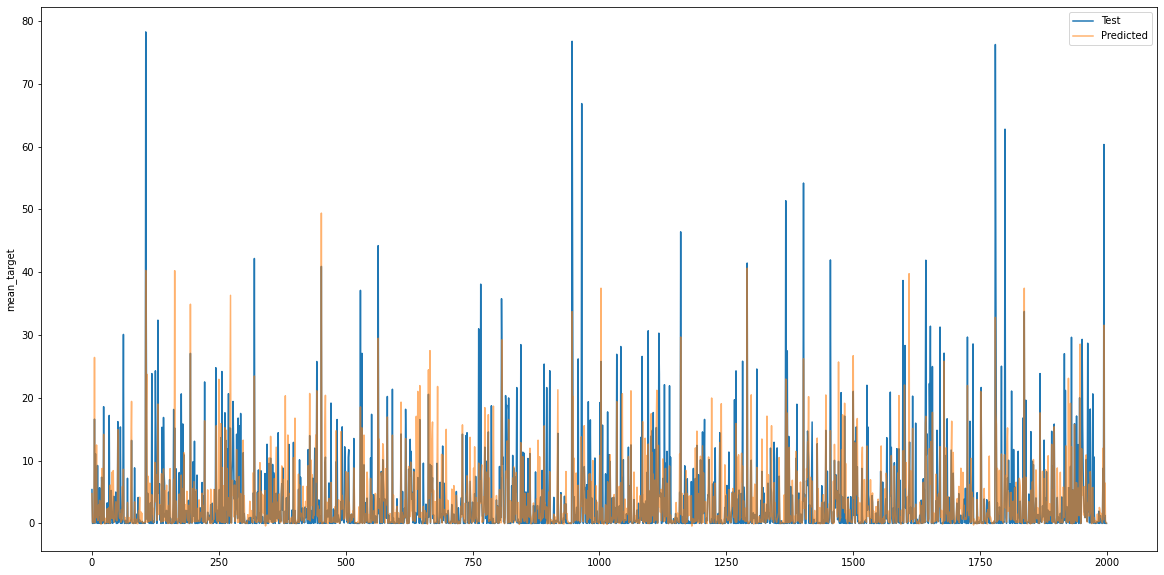

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.lineplot(range(len(y_test[:2000])), y_test[:2000], label='Test')
sns.lineplot(range(len(y_pred[:2000])), y_pred[:2000], label='Predicted', alpha=0.6)

plt.show()

**the model is generally able to predict if it's raining or not, but the magnitude of the precipitation is not predicted well.**

### only rain gauges measurements and distances 

Here I test if using only the rain gauges measurements and distances improves the score

In [ ]:
merged_df.head()

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-02  7070614140     0.000000                          1   
2       2010-01-03  7070614140     0.066356                          1   
3       2010-01-04  7070614140     2.259621                          1   
4       2010-01-05  7070614140     0.786227                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  4.737519e+09     881.629906        1720.0         558.0          27      0   
2  4.737519e+09     881.629906        1720.0         558.0          27      0   
3  4.737519e+09     881.629906        1720.0         558.0          27      0   
4  4.737519e+09     881.629906        1720.0         558.0          27      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  US1NCAG0003_x  \
0     0        0.0  53.615608   10.822695            0.5       0.251346   
1     0        0.0  53.615608   10.822695            0.0       0.000000   
2     0        0.0  53.615608   10.822695            0.0       0.000000   
3     0        0.0  53.615608   10.822695            0.0       0.000000   
4     0        0.0  53.615608   10.822695            0.0       0.000000   

   US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  US1NCAS0002_x  US1NCAS0010_x  \
0       0.210234       0.000000       0.030869            3.8       0.678797   
1       0.196219       0.000000       0.000000            1.3       0.737238   
2       0.000000       0.000000       0.000000            0.3       0.000000   
3       0.000000       0.000000       0.000000            0.5       0.453896   
4       0.104276       0.118067       0.000000            3.3       0.963228   

   US1NCAS0012_x  US1NCAS0013_x  US1NCAS0014_x  US1NCAS0016_x  US1NCAS0018_x  \
0       2.115599       0.183479       0.280560       1.827020       0.882811   
1       0.816623       0.248120       0.243124       0.649900       0.473078   
2       0.000000       0.000000       0.000000       1.951736       0.298154   
3       0.352670       0.000000       0.090170       0.452275       0.506438   
4       1.654946       0.073324       0.435745       0.653260       0.676467   

   US1NCAS0019_x  US1NCAS0022_x  US1NCAV0004_x  US1NCAV0007_x  US1NCAV0009_x  \
0       0.048052       0.779565       1.003572            0.0       0.621739   
1       0.134127       0.639341       0.276723            0.3       0.455313   
2       0.000000       0.000000       0.000000            0.0       0.000000   
3       0.218358       0.130013       0.500000            0.0       0.136923   
4       0.172623       0.451157       1.837528            0.3       0.934669   

   US1NCAX0005_x  US1NCAX0006_x  US1NCAX0007_x  US1NCBC0087_x  US1NCBC0115_x  \
0      11.027281       0.443717       2.168575       0.175596       0.748805   
1      10.621181       0.000000       3.977759       0.026386       0.299801   
2       9.192943       0.000000      21.600000       0.000000       0.167780   
3      10.166030       0.000000       4.177221       0.171487       0.651630   
4       9.753188       0.031186       4.532307       0.071883       0.311505   

   US1NCBK0002_x  US1NCBK0004_x  US1NCBK0006_x  US1NCBK0009_x  US1NCBK0012_x  \
0       0.211298       0.130082       2.311059       0.234519       0.031627   
1       0.000000       0.026850       1.207470       0.000000       0.000000   
2       0.000000       0.000000       0.134459       0.000000       0.000000   
3       0.000000       0.000000       0.507637       0.000000       0.273482   
4       0.041997       0.000000       0.137940       0.061650       0.447660   

   US1NCBK0013_x  US1NCCB0008_x  US1NCCB0010_x  US1NCCB0015_x  US1NCCB0020_x  \
0       0.800699            1.8       0.323983       0.527702       0.394928   
1       0.205548            0.0       0.000000       0

In [ ]:
dates= merged_df.measurement_date.unique()

In [ ]:
dates_train ,dates_test = train_test_split(dates,test_size=0.2, random_state = 42) 


In [ ]:
dates_train.shape

(3359,)

In [ ]:
dates_test.shape

(840,)

In [ ]:
train = merged_df[(merged_df.measurement_date.isin(dates_train))]
test = merged_df[(merged_df.measurement_date.isin(dates_test))]



In [ ]:
train.shape

(62318, 525)

In [ ]:
test.shape

(15538, 525)

In [ ]:
train.head(5)

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0       2010-01-01  7070614140     5.331242                          1   
1       2010-01-02  7070614140     0.000000                          1   
2       2010-01-03  7070614140     0.066356                          1   
3       2010-01-04  7070614140     2.259621                          1   
4       2010-01-05  7070614140     0.786227                          1   

           area  altitude_mean  altitude_max  altitude_min  num_gauges  coast  \
0  4.737519e+09     881.629906        1720.0         558.0          27      0   
1  4.737519e+09     881.629906        1720.0         558.0          27      0   
2  4.737519e+09     881.629906        1720.0         558.0          27      0   
3  4.737519e+09     881.629906        1720.0         558.0          27      0   
4  4.737519e+09     881.629906        1720.0         558.0          27      0   

   lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  US1NCAG0003_x  \
0     0        0.0  53.615608   10.822695            0.5       0.251346   
1     0        0.0  53.615608   10.822695            0.0       0.000000   
2     0        0.0  53.615608   10.822695            0.0       0.000000   
3     0        0.0  53.615608   10.822695            0.0       0.000000   
4     0        0.0  53.615608   10.822695            0.0       0.000000   

   US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  US1NCAS0002_x  US1NCAS0010_x  \
0       0.210234       0.000000       0.030869            3.8       0.678797   
1       0.196219       0.000000       0.000000            1.3       0.737238   
2       0.000000       0.000000       0.000000            0.3       0.000000   
3       0.000000       0.000000       0.000000            0.5       0.453896   
4       0.104276       0.118067       0.000000            3.3       0.963228   

   US1NCAS0012_x  US1NCAS0013_x  US1NCAS0014_x  US1NCAS0016_x  US1NCAS0018_x  \
0       2.115599       0.183479       0.280560       1.827020       0.882811   
1       0.816623       0.248120       0.243124       0.649900       0.473078   
2       0.000000       0.000000       0.000000       1.951736       0.298154   
3       0.352670       0.000000       0.090170       0.452275       0.506438   
4       1.654946       0.073324       0.435745       0.653260       0.676467   

   US1NCAS0019_x  US1NCAS0022_x  US1NCAV0004_x  US1NCAV0007_x  US1NCAV0009_x  \
0       0.048052       0.779565       1.003572            0.0       0.621739   
1       0.134127       0.639341       0.276723            0.3       0.455313   
2       0.000000       0.000000       0.000000            0.0       0.000000   
3       0.218358       0.130013       0.500000            0.0       0.136923   
4       0.172623       0.451157       1.837528            0.3       0.934669   

   US1NCAX0005_x  US1NCAX0006_x  US1NCAX0007_x  US1NCBC0087_x  US1NCBC0115_x  \
0      11.027281       0.443717       2.168575       0.175596       0.748805   
1      10.621181       0.000000       3.977759       0.026386       0.299801   
2       9.192943       0.000000      21.600000       0.000000       0.167780   
3      10.166030       0.000000       4.177221       0.171487       0.651630   
4       9.753188       0.031186       4.532307       0.071883       0.311505   

   US1NCBK0002_x  US1NCBK0004_x  US1NCBK0006_x  US1NCBK0009_x  US1NCBK0012_x  \
0       0.211298       0.130082       2.311059       0.234519       0.031627   
1       0.000000       0.026850       1.207470       0.000000       0.000000   
2       0.000000       0.000000       0.134459       0.000000       0.000000   
3       0.000000       0.000000       0.507637       0.000000       0.273482   
4       0.041997       0.000000       0.137940       0.061650       0.447660   

   US1NCBK0013_x  US1NCCB0008_x  US1NCCB0010_x  US1NCCB0015_x  US1NCCB0020_x  \
0       0.800699            1.8       0.323983       0.527702       0.394928   
1       0.205548            0.0       0.000000       0

In [ ]:
train[train.mean_target > 5]

measurement_date    hybas_id  mean_target  month(m.measurement_date)  \
0           2010-01-01  7070614140     5.331242                          1   
10          2010-01-11  7070614140    10.862233                          1   
16          2010-01-17  7070614140    46.457578                          1   
20          2010-01-21  7070614140     9.130240                          1   
24          2010-01-25  7070614140    33.045567                          1   
...                ...         ...          ...                        ...   
77821       2020-08-15  7070610540    36.357842                          8   
77827       2020-08-21  7070610540    15.640021                          8   
77834       2020-08-28  7070610540     6.133364                          8   
77835       2020-08-29  7070610540    10.724038                          8   
77854       2020-09-17  7070610540    30.904907                          9   

               area  altitude_mean  altitude_max  altitude_min  num_gauges  \
0      4.737519e+09     881.629906        1720.0         558.0          27   
10     4.737519e+09     881.629906        1720.0         558.0          27   
16     4.737519e+09     881.629906        1720.0         558.0          27   
20     4.737519e+09     881.629906        1720.0         558.0          27   
24     4.737519e+09     881.629906        1720.0         558.0          27   
...             ...            ...           ...           ...         ...   
77821  8.850506e+08     745.979904        1081.0         529.0           1   
77827  8.850506e+08     745.979904        1081.0         529.0           1   
77834  8.850506e+08     745.979904        1081.0         529.0           1   
77835  8.850506e+08     745.979904        1081.0         529.0           1   
77854  8.850506e+08     745.979904        1081.0         529.0           1   

       coast  lake  slope_min  slope_max  slope_mean  US1NCAG0001_x  \
0          0     0        0.0  53.615608   10.822695            0.5   
10         0     0        0.0  53.615608   10.822695            0.0   
16         0     0        0.0  53.615608   10.822695           50.8   
20         0     0        0.0  53.615608   10.822695            2.3   
24         0     0        0.0  53.615608   10.822695           83.3   
...      ...   ...        ...        ...         ...            ...   
77821      0     0        0.0  54.794292    8.913439           11.2   
77827      0     0        0.0  54.794292    8.913439           28.2   
77834      0     0        0.0  54.794292    8.913439            0.0   
77835      0     0        0.0  54.794292    8.913439            4.8   
77854      0     0        0.0  54.794292    8.913439            3.3   

       US1NCAG0003_x  US1NCAG0004_x  US1NCAG0005_x  US1NCAS0001_x  \
0           0.251346       0.210234       0.000000       0.030869   
10          0.000000       0.047413       0.000000       0.000000   
16         40.167541      29.638278      31.565521      34.800256   
20          0.818317       2.155593       0.698505       0.376196   
24         81.761690      29.883283      61.350586      34.573295   
...              ...            ...            ...            ...   
77821      19.030562      13.671831      19.100000      20.298894   
77827      14.814498       3.830069       9.100000      10.610545   
77834       0.000000       0.030250       0.000000       0.049724   
77835       4.231248       3.139021       4.100000       3.131936   
77854       6.028043       6.181689       2.800000      10.398644   

       US1NCAS0002_x  US1NCAS0010_x  US1NCAS0012_x  US1NCAS0013_x  \
0           3.800000       0.678797       2.115599       0.183479   
10          0.000000       0.000000       0.000000       0.000000   
16         31.500000      39.082163      26.591808      44.271260   
20          1.536072       2.335931       1.348796       1.641755   
24         48.012788      48.926239      40.674983      84.439338   
...              ...            ... 

In [ ]:
X_train = train.drop(columns=['mean_target', "measurement_date"])
y_train = train['mean_target'] 

X_test = test.drop(columns=['mean_target', "measurement_date"])
y_test = test['mean_target']

In [ ]:
from xgboost import XGBRegressor


scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
xgb = XGBRegressor(n_estimators=200, max_depth = 20)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.3098130869738721

**By removing the aggregated statistics of the catchment, the score decreases**

## Testing on multiple areas

In this section I tested the train and tested the same model on different areas of the US. Since considering the whole US would have been too time comsuming, I considered only the area between the 20th and the 35th parallels and the 80th and 100th meridians. 

In [ ]:
latitude = range(20,35,2)
longitude = range(-100,-80,2)

The following cell won't run, as the database won't be online after the handout.

It iterately considers the different areas and calculates for each area:
* score of the predition
* the shape of the dataframe that was used for training 
* the number of not imputed over the number of imputed values.  

The resulting dataframe (df_scores.csv) is provided.


In [ ]:
n_nan = []
shapes = []
shapes_higher_5 = []
test_scores = []
df_scores = pd.DataFrame(columns=['HYBAS_ID', 'Score'])
hyb_al_ch = []

for lat in latitude:
  for lon in longitude:


    sql_query = """SELECT  m.station, m.measurement_date , MONTH(m.measurement_date), m.prcp, t.mean_target, f.HYBAS_ID, c.Area, c.Altitude_Mean, c.Altitude_Max, c.Altitude_Min, c.Num_Gauges, c.Side, c.Coast, c.Lake, c.Slope_Min, c.Slope_Max, c.Slope_Mean
    FROM catchment_features c
    INNER JOIN precipitation_gauge_features f ON f.hybas_id = c.hybas_id
    INNER JOIN precipitation_gauge_measurements m ON m.station = f.station 
    INNER JOIN second_target t ON t.zone = c.hybas_id AND t.date_target = m.measurement_date
    WHERE c.CENTROID_LATITUDE < """+str(lat+2)+""" AND c.CENTROID_LATITUDE >"""+str(lat)+""" AND c.CENTROID_LONGITUDE  >"""+str(lon-2)+""" AND c.CENTROID_LONGITUDE  < """+str(lon)+""";"""

    print(lat,lon)
    cursor = ctx.cursor()
    cursor.execute(sql_query)
    data = cursor.fetchall()
    num_fields = len(cursor.description)
    columns = [i[0].lower() for i in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    cursor.close()
    if (df.station.nunique() < 10) | (df.hybas_id.nunique() < 3):
      print(lat,lon)
      continue
    df = df[~df['hybas_id'].isin(hyb_al_ch)]
    print(df.hybas_id.unique())
    if df.hybas_id.unique() is not None:
      hyb_al_ch.append(df.hybas_id.unique())
    #print(hyb_al_ch)
    df["measurement_date"] = pd.to_datetime(df["measurement_date"])
    df["prcp"] = df["prcp"].astype(float)
    
    stats = df.groupby(['hybas_id', 'measurement_date'])['prcp'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.10),lambda x: x.quantile(0.20), lambda x: x.quantile(0.30), lambda x: x.quantile(0.40) ,lambda x: x.quantile(0.60), lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), lambda x: x.quantile(0.90)])

    stats = stats.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q2', '<lambda_2>': 'q3', '<lambda_3>': 'q4', '<lambda_4>': 'q6', '<lambda_5>': 'q7', '<lambda_6>': 'q8', '<lambda_7>': 'q9'})

    dfp = df.pivot(values=["prcp"], index=["measurement_date","hybas_id", "mean_target", "month(m.measurement_date)", "area", "altitude_mean", "altitude_max", "altitude_min", "num_gauges", "coast", "lake", "slope_min", "slope_max", "slope_mean"], columns=["station"])
    dfp_prcp = dfp.prcp
    grouped = dfp_prcp.groupby(['measurement_date']).max()

    # Set number of neighbors to look for
    neighbors = 10

    # Initialize KNN regressor
    knn_regressor = KNNImputer(n_neighbors = neighbors, weights = "distance")

    # Fit regressor to data
    grouped_imputed = knn_regressor.fit_transform(grouped)

    grouped_imputed = pd.DataFrame(grouped_imputed, columns=grouped.columns, index=grouped.index)
    dfp_frame = dfp.index.to_frame().reset_index(drop=True)
    merged_df = pd.merge(dfp_frame,grouped_imputed, how='left', on='measurement_date')
    
    distance_df = pd.DataFrame(0, index=df.hybas_id.unique().tolist(), columns=df.station.unique().tolist())
    for col_name, col_data in distance_df.iteritems():
      for idx, row in distance_df.iterrows():
        distance_df.loc[idx, col_name] = sqrt(   (cf[cf.HYBAS_ID == int(idx)].centroid_latitude.iloc[0] - pgf[pgf.station == col_name].latitude.iloc[0])**2    +    (cf[cf.HYBAS_ID == int(idx)].centroid_longitude.iloc[0] - pgf[pgf.station == col_name].longitude.iloc[0])**2   )

    distance_df = distance_df.reset_index()
    merged_df = pd.merge(merged_df, distance_df, how='inner', left_on="hybas_id", right_on="index" )
    merged_df = merged_df.drop(columns = "index")

    merged_df = pd.merge(merged_df, stats, how='inner', on=["hybas_id", "measurement_date"])

    shapes.append(merged_df.shape)
    
    dates= merged_df.measurement_date.unique()
    dates_train ,dates_test = train_test_split(dates,test_size=0.2, random_state = 20) 
    train = merged_df[(merged_df.measurement_date.isin(dates_train))]
    test = merged_df[(merged_df.measurement_date.isin(dates_test))]
    X_train = train.drop(columns=['mean_target', "measurement_date"])
    y_train = train['mean_target'] 

    X_test = test.drop(columns=['mean_target', "measurement_date"])
    y_test = test['mean_target']
    
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    xgb = XGBRegressor(n_estimators=200, max_depth = 20)
    xgb.fit(X_train, y_train)
    print(xgb.score(X_test, y_test))



    test_score = xgb.score(X_test, y_test)
    test_scores.append(test_score)
    hybas_ids = df.hybas_id.unique().tolist()
    scores = [test_score] * len(hybas_ids)
    n_nan = [grouped.isnull().sum().sum()] * len(hybas_ids)
    n_not_nan = [np.sum(grouped.count())] * len(hybas_ids)
    not_imputed_over_imputed  = np.array(n_not_nan) / np.array(n_nan) 
    shape_training = [merged_df[merged_df.mean_target > 5].shape] * len(hybas_ids)
    zipped = list(zip(hybas_ids, scores, shape_training, not_imputed_over_imputed))
    df_scores_region = pd.DataFrame(zipped, columns=['HYBAS_ID', 'Score',"Shape_training", "not_imputed_over_imputed"])
    df_scores = pd.concat([df_scores, df_scores_region],ignore_index = True)




In [ ]:
df_scores = pd.read_csv('df_scores.csv')

In [ ]:
df_scores = df_scores.drop(columns = ["Unnamed: 0", "Unnamed: 0.1"])

In [ ]:
df_scores.head()

HYBAS_ID     Score Shape_training  not_imputed_over_imputed
0  7070048990  0.526272    (2687, 148)                  0.776141
1  7070786790  0.526272    (2687, 148)                  0.776141
2  7070049270  0.526272    (2687, 148)                  0.776141
3  7070794420  0.526272    (2687, 148)                  0.776141
4  7070786830  0.526272    (2687, 148)                  0.776141

In [ ]:
df_scores.Score.mean()

0.5334660147176449

**The score is not crossvalidated but we can be confident that the real score is around that number since the area considered is quite big.**

### plot the map with the catchments

with the following cell, it is possible to plot the values on a map.

In [ ]:
df_scores['HYBAS_ID'] = df_scores['HYBAS_ID'].astype('int64')
catchmet_features_from_gpkg_onc = catchmet_features_from_gpkg[["HYBAS_ID", "geometry"]]
joined_df_catch = pd.merge(df_scores, catchmet_features_from_gpkg_onc, on = "HYBAS_ID")
geo_joined_catch_df = gpd.GeoDataFrame(joined_df_catch)
geo_catch = geo_joined_catch_df.explore(column="Score")
folium.TileLayer('Stamen Toner', control=True).add_to(geo_catch)  # use folium to add alternative tiles
folium.LayerControl().add_to(geo_catch)  # use folium to add layer control

outfp = r"combined.html"

geo_catch.save(outfp)

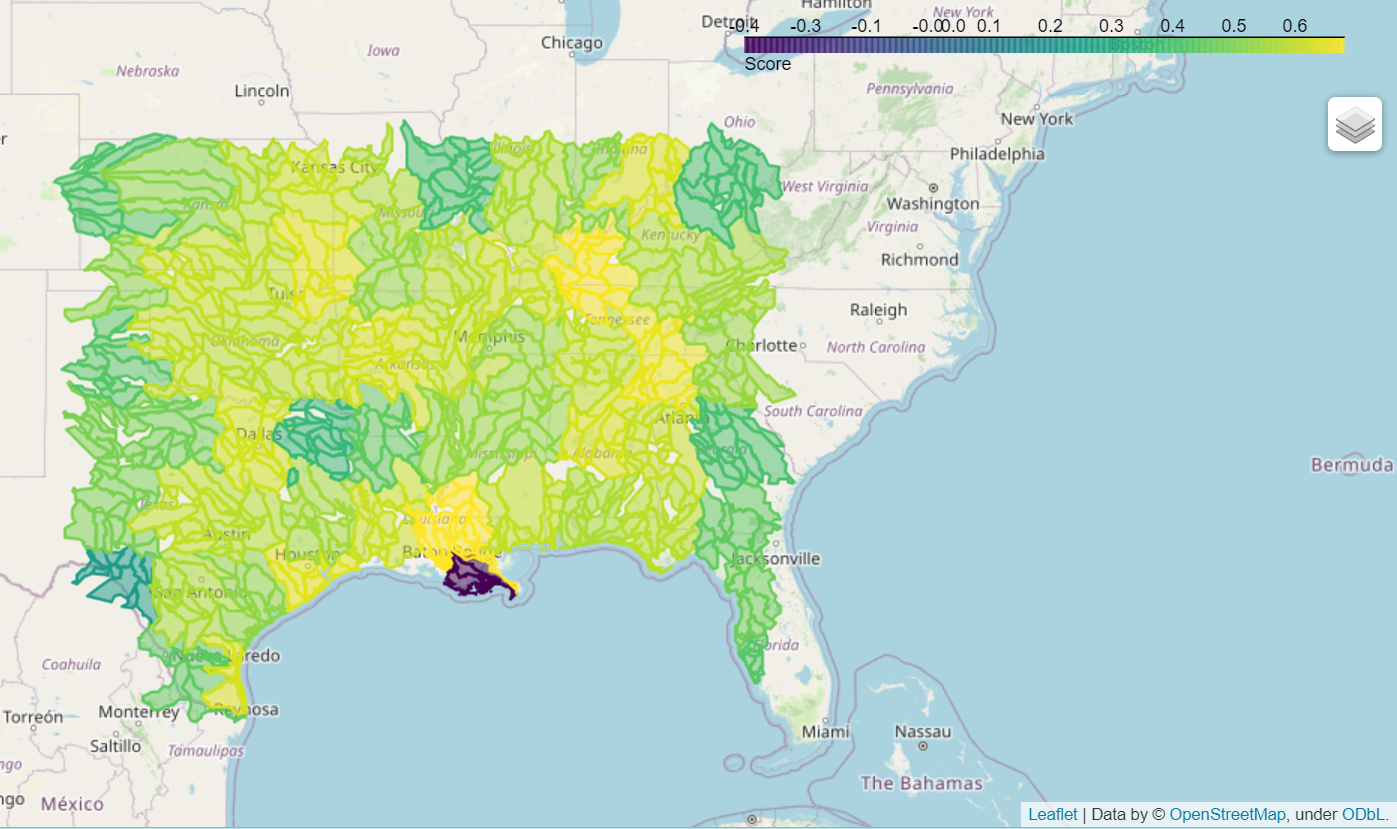

### Result analysis

It is reasonable to think that, if the number of imputed data increases, than the score should decrease, however it doesn't seem to be the case.

<AxesSubplot:xlabel='not_imputed_over_imputed', ylabel='Score'>

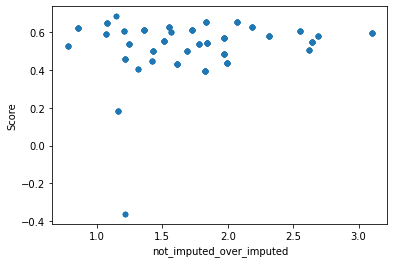

In [ ]:
df_scores.plot.scatter("not_imputed_over_imputed", "Score")

It would be also reasonable to think that the score improves, if the number of training rows increases. I tested it in the next cells.

In [ ]:
import ast

df_scores['Shape_training'] = df_scores['Shape_training'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_scores['N_Row_Training'] = df_scores['Shape_training'].apply(lambda x: x[0])
df_scores['N_Columns_Training'] = df_scores['Shape_training'].apply(lambda x: x[1])
df_scores.head()


HYBAS_ID     Score Shape_training  not_imputed_over_imputed  \
0  7070048990  0.526272    (2687, 148)                  0.776141   
1  7070786790  0.526272    (2687, 148)                  0.776141   
2  7070049270  0.526272    (2687, 148)                  0.776141   
3  7070794420  0.526272    (2687, 148)                  0.776141   
4  7070786830  0.526272    (2687, 148)                  0.776141   

   N_Row_Training  N_Columns_Training  
0            2687                 148  
1            2687                 148  
2            2687                 148  
3            2687                 148  
4            2687                 148

<AxesSubplot:xlabel='N_Row_Training', ylabel='Score'>

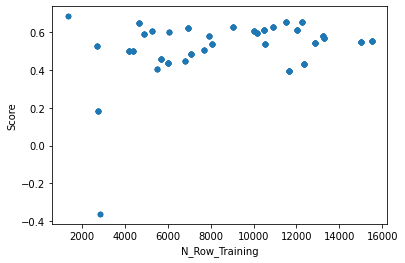

In [ ]:
df_scores.plot.scatter("N_Row_Training", "Score")

Scores lower than 0.4 were only obtained by training dataframes with less than 4K rows. This suggests that acceptable scores can only be obtained with enough training rows. 

The same seems to be true for the number of columns. The graph seems to suggest that wide areas (areas with more rain gauges) provide a better score.

<AxesSubplot:xlabel='N_Columns_Training', ylabel='Score'>

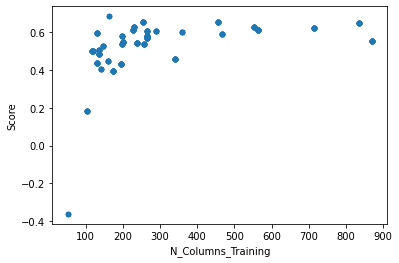

In [ ]:
df_scores.plot.scatter("N_Columns_Training", "Score")

### Conclusion
The model is able to reach R2 scores around 0.6, if the number of rows for training is sufficiently high. However, the major drawback for this model is not having the possibility to increase the number of rows for training. 
By increasing the size of the area, it is possible to increase the number of rows, however the same would be true for the number of columns (which is dependent on the number of rain gauges). 
Dataframes from different areas cannot be vertically concatenated, since all areas have a different amount of rain gauges.  
One possible solution would be to consider only a maximum amount of rain gauges and eliminate the rain gauges based on the number of imputed values for example. This way the number of rain gauges is fixed and the rows from different areas can be concatenated for training.